In [1]:
!git clone https://github.com/osmr/imgclsmob.git
!pip install -r /kaggle/working/imgclsmob/requirements.txt

Cloning into 'imgclsmob'...
remote: Enumerating objects: 30269, done.
remote: Counting objects: 100% (1509/1509), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 30269 (delta 1332), reused 1417 (delta 1332), pack-reused 28760
Receiving objects: 100% (30269/30269), 13.75 MiB | 19.81 MiB/s, done.
Resolving deltas: 100% (25793/25793), done.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/content/imgclsmob/requirements.txt'


In [2]:
from imgclsmob.pytorch.pytorchcv.models.cbamresnet import *

In [3]:
!pip install timm torchinfo

In [4]:
import os
import sys
import cv2
import glob
import math
import time
import timm
import torch
import random
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import multiprocessing
from pathlib import Path
import concurrent.futures
from torch import nn, optim
from tabulate import tabulate
from torchinfo import summary
from datetime import timedelta
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
from functools import partial, lru_cache
from torchvision.datasets import ImageFolder
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import Resize, ToTensor
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, random_split
from concurrent.futures import ThreadPoolExecutor, as_completed
from timm.models.vision_transformer import Block as transformer_block
from collections import defaultdict, Counter
from timm.models.registry import register_model
from torch.utils.data import DataLoader
from timm.models.layers import trunc_normal_
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
dataset = Path(r"/kaggle/input/")
covid_19 = dataset / "covid19-radiography-database" / "COVID-19_Radiography_Dataset"

In [8]:
class_names = [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]
image_paths = []
labels = []

for class_name in class_names:
    class_dir = covid_19 / class_name / 'images'
    if os.path.exists(class_dir):
        file_names = [f_name for f_name in os.listdir(class_dir) if f_name.endswith((".jpeg", ".png"))]

        for f_name in tqdm(file_names, desc=f"Processing {class_name}"):
            image_paths.append(os.path.join(class_dir, f_name))
            labels.append(class_name)

Processing COVID: 100%|██████████| 3616/3616 [00:00<00:00, 275116.15it/s]


In [13]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

In [14]:
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths,
                                                                      labels_encoded,
                                                                      test_size=0.1,
                                                                      random_state=42,
                                                                      stratify=labels_encoded)

train_paths, test_paths, train_labels, test_labels= train_test_split(train_paths,
                                                                    train_labels,
                                                                    test_size=0.2222,
                                                                    random_state=42,
                                                                    stratify=train_labels)
train_df = pd.DataFrame({'File Paths': train_paths, 'Labels': train_labels})
val_df = pd.DataFrame({'File Paths': val_paths, 'Labels': val_labels})
test_df = pd.DataFrame({'File Paths': test_paths, 'Labels': test_labels})

total_train_samples = len(train_df)
total_val_samples = len(val_df)
total_test_samples = len(test_df)

train_percentage = (total_train_samples / len(labels_encoded)) * 100
val_percentage = (total_val_samples / len(labels_encoded)) * 100
test_percentage = (total_test_samples / len(labels_encoded)) * 100

train_counts = train_df['Labels'].value_counts().sort_index()
val_counts = val_df['Labels'].value_counts().sort_index()
test_counts = test_df['Labels'].value_counts().sort_index()

train_df = pd.DataFrame({'Train Samples': train_counts})
val_df = pd.DataFrame({'Validation Samples': val_counts})
test_df = pd.DataFrame({'Test Samples': test_counts})

train_df.index = val_df.index = test_df.index = class_names

print("Total Train Samples:", total_train_samples)
print("Total Validation Samples:", total_val_samples)
print("Total Test Samples:", total_test_samples)
print("\nPercentage of Split:")
print("Train: {:.2f}%".format(train_percentage))
print("Validation: {:.2f}%".format(val_percentage))
print("Test: {:.2f}%".format(test_percentage))
print("\nClass Distribution:")
result_df = pd.concat([train_df, val_df, test_df], axis=1)
print(result_df)

Total Train Samples: 14815
Total Validation Samples: 2117
Total Test Samples: 4233

Percentage of Split:
Train: 70.00%
Validation: 10.00%
Test: 20.00%

Class Distribution:
                 Train Samples  Validation Samples  Test Samples
Normal                    2531                 362           723
Lung_Opacity              4209                 601          1202
Viral Pneumonia           7134                1019          2039
COVID                      941                 135           269


In [15]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, img_labels, transform=None):
        """
        Custom Dataset class to load and preprocess images.

        Args:
            img_paths (list): List of image file paths.
            img_labels (list): List of corresponding image labels.
            transform (callable, optional): Transform to apply to images. Defaults to None.
        """
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = cv2.imread(str(self.img_paths[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        pil_img = Image.fromarray(img)

        transformed_img = self.transform(pil_img)  

        label = self.img_labels[index]
        return transformed_img, label
BATCH_SIZE = 16

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = ImageDataset(train_paths, train_labels, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

val_dataset = ImageDataset(val_paths, val_labels, transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

test_dataset = ImageDataset(test_paths, test_labels, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

train_steps = len(train_loader)
val_steps = len(val_loader)
test_steps = len(test_loader)

In [17]:
model = cbam_resnet152()
model.output = nn.Linear(model.output.in_features, num_classes)
model.to(device)
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
CbamResNet                                              [1, 4]                    --
├─Sequential: 1-1                                       [1, 2048, 1, 1]           --
│    └─ResInitBlock: 2-1                                [1, 64, 56, 56]           --
│    │    └─ConvBlock: 3-1                              [1, 64, 112, 112]         9,536
│    │    └─MaxPool2d: 3-2                              [1, 64, 56, 56]           --
│    └─Sequential: 2-2                                  [1, 256, 56, 56]          --
│    │    └─CbamResUnit: 3-3                            [1, 256, 56, 56]          83,572
│    │    └─CbamResUnit: 3-4                            [1, 256, 56, 56]          78,964
│    │    └─CbamResUnit: 3-5                            [1, 256, 56, 56]          78,964
│    └─Sequential: 2-3                                  [1, 512, 28, 28]          --
│    │    └─CbamResUnit: 3-6                 

In [18]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)

    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    auc_avg = np.mean(auc_scores)

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [19]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [20]:
patience = 10
current_patience = 0
best_val_loss = float('inf')

metric_names = ["loss", "accuracy", "precision", "recall", "f1_score", "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(total_epochs):
    start_time = time.time()

    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{total_epochs}")):
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(data)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
        all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    average_loss = total_loss / len(train_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validation")):
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
            all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    average_loss = total_loss / len(val_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    print(f"Epoch {epoch + 1}/{total_epochs}")
    print(f"Train - loss: {average_loss:.4f} - accuracy: {train_metrics['accuracy']:.4f} - precision: {train_metrics['precision']:.4f} - recall: {train_metrics['recall']:.4f} - f1_score: {train_metrics['f1_score']:.4f} - specificity: {train_metrics['specificity']:.4f} - sensitivity: {train_metrics['sensitivity']:.4f} - mcc: {train_metrics['mcc']:.4f} - auc: {train_metrics['auc']:.4f}")
    print(f"Val - loss: {average_loss:.4f} - accuracy: {val_metrics['accuracy']:.4f} - precision: {val_metrics['precision']:.4f} - recall: {val_metrics['recall']:.4f} - f1_score: {val_metrics['f1_score']:.4f} - specificity: {val_metrics['specificity']:.4f} - sensitivity: {val_metrics['sensitivity']:.4f} - mcc: {val_metrics['mcc']:.4f} - auc: {val_metrics['auc']:.4f}")

    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])
        val_metrics_history[metric_name].append(val_metrics[metric_name])

    if average_loss < best_val_loss:
        best_val_loss = average_loss
        current_patience = 0
    else:
        current_patience += 1

    if current_patience >= patience:
        print(f"Early stopping at epoch {epoch + 1} due to lack of improvement in validation loss.")
        break

Validation: 100%|██████████| 133/133 [00:15<00:00,  8.61it/s]


Epoch 1/50
Train - loss: 0.4006 - accuracy: 0.7716 - precision: 0.7712 - recall: 0.7716 - f1_score: 0.7693 - specificity: 0.6630 - sensitivity: 0.9547 - mcc: 0.6450 - auc: 0.9256
Val - loss: 0.4006 - accuracy: 0.8470 - precision: 0.8473 - recall: 0.8470 - f1_score: 0.8468 - specificity: 0.9006 - sensitivity: 0.9647 - mcc: 0.7663 - auc: 0.9657


Validation: 100%|██████████| 133/133 [00:15<00:00,  8.63it/s]


Epoch 2/50
Train - loss: 0.3403 - accuracy: 0.8680 - precision: 0.8678 - recall: 0.8680 - f1_score: 0.8674 - specificity: 0.8740 - sensitivity: 0.9761 - mcc: 0.7972 - auc: 0.9707
Val - loss: 0.3403 - accuracy: 0.8762 - precision: 0.8774 - recall: 0.8762 - f1_score: 0.8758 - specificity: 0.9006 - sensitivity: 0.9795 - mcc: 0.8093 - auc: 0.9729


Validation: 100%|██████████| 133/133 [00:15<00:00,  8.62it/s]


Epoch 3/50
Train - loss: 0.3949 - accuracy: 0.8972 - precision: 0.8971 - recall: 0.8972 - f1_score: 0.8968 - specificity: 0.9147 - sensitivity: 0.9835 - mcc: 0.8423 - auc: 0.9805
Val - loss: 0.3949 - accuracy: 0.8607 - precision: 0.8722 - recall: 0.8607 - f1_score: 0.8616 - specificity: 0.9751 - sensitivity: 0.9231 - mcc: 0.7961 - auc: 0.9758


Validation: 100%|██████████| 133/133 [00:15<00:00,  8.63it/s]


Epoch 4/50
Train - loss: 0.5235 - accuracy: 0.9172 - precision: 0.9171 - recall: 0.9172 - f1_score: 0.9169 - specificity: 0.9443 - sensitivity: 0.9894 - mcc: 0.8730 - auc: 0.9862
Val - loss: 0.5235 - accuracy: 0.8337 - precision: 0.8509 - recall: 0.8337 - f1_score: 0.8290 - specificity: 0.9392 - sensitivity: 0.9464 - mcc: 0.7509 - auc: 0.9637


Validation: 100%|██████████| 133/133 [00:15<00:00,  8.64it/s]


Epoch 5/50
Train - loss: 0.2918 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - f1_score: 0.9266 - specificity: 0.9530 - sensitivity: 0.9914 - mcc: 0.8879 - auc: 0.9894
Val - loss: 0.2918 - accuracy: 0.8923 - precision: 0.8940 - recall: 0.8923 - f1_score: 0.8927 - specificity: 0.9199 - sensitivity: 0.9869 - mcc: 0.8353 - auc: 0.9817


Validation: 100%|██████████| 133/133 [00:15<00:00,  8.62it/s]


Epoch 6/50
Train - loss: 0.2390 - accuracy: 0.9340 - precision: 0.9339 - recall: 0.9340 - f1_score: 0.9338 - specificity: 0.9546 - sensitivity: 0.9920 - mcc: 0.8989 - auc: 0.9919
Val - loss: 0.2390 - accuracy: 0.9178 - precision: 0.9177 - recall: 0.9178 - f1_score: 0.9177 - specificity: 0.9586 - sensitivity: 0.9903 - mcc: 0.8746 - auc: 0.9853


Validation: 100%|██████████| 133/133 [00:15<00:00,  8.63it/s]


Epoch 7/50
Train - loss: 0.3044 - accuracy: 0.9465 - precision: 0.9464 - recall: 0.9465 - f1_score: 0.9464 - specificity: 0.9660 - sensitivity: 0.9935 - mcc: 0.9181 - auc: 0.9943
Val - loss: 0.3044 - accuracy: 0.9027 - precision: 0.9043 - recall: 0.9027 - f1_score: 0.9020 - specificity: 0.9227 - sensitivity: 0.9909 - mcc: 0.8508 - auc: 0.9792


Validation: 100%|██████████| 133/133 [00:15<00:00,  8.65it/s]


Epoch 8/50
Train - loss: 0.3492 - accuracy: 0.9553 - precision: 0.9552 - recall: 0.9553 - f1_score: 0.9552 - specificity: 0.9751 - sensitivity: 0.9949 - mcc: 0.9316 - auc: 0.9959
Val - loss: 0.3492 - accuracy: 0.8744 - precision: 0.8835 - recall: 0.8744 - f1_score: 0.8745 - specificity: 0.9613 - sensitivity: 0.9630 - mcc: 0.8175 - auc: 0.9830


Validation: 100%|██████████| 133/133 [00:15<00:00,  8.63it/s]


Epoch 9/50
Train - loss: 0.2759 - accuracy: 0.9654 - precision: 0.9653 - recall: 0.9654 - f1_score: 0.9653 - specificity: 0.9731 - sensitivity: 0.9954 - mcc: 0.9470 - auc: 0.9975
Val - loss: 0.2759 - accuracy: 0.9140 - precision: 0.9150 - recall: 0.9140 - f1_score: 0.9143 - specificity: 0.9365 - sensitivity: 0.9909 - mcc: 0.8690 - auc: 0.9850


Validation: 100%|██████████| 133/133 [00:15<00:00,  8.66it/s]


Epoch 10/50
Train - loss: 0.3183 - accuracy: 0.9690 - precision: 0.9689 - recall: 0.9690 - f1_score: 0.9689 - specificity: 0.9806 - sensitivity: 0.9967 - mcc: 0.9525 - auc: 0.9981
Val - loss: 0.3183 - accuracy: 0.9046 - precision: 0.9069 - recall: 0.9046 - f1_score: 0.9048 - specificity: 0.9807 - sensitivity: 0.9846 - mcc: 0.8567 - auc: 0.9852


Validation: 100%|██████████| 133/133 [00:15<00:00,  8.66it/s]


Epoch 11/50
Train - loss: 0.2933 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - f1_score: 0.9741 - specificity: 0.9791 - sensitivity: 0.9958 - mcc: 0.9604 - auc: 0.9988
Val - loss: 0.2933 - accuracy: 0.9069 - precision: 0.9094 - recall: 0.9069 - f1_score: 0.9076 - specificity: 0.9337 - sensitivity: 0.9897 - mcc: 0.8585 - auc: 0.9849


Validation: 100%|██████████| 133/133 [00:15<00:00,  8.66it/s]


Epoch 12/50
Train - loss: 0.4046 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - f1_score: 0.9786 - specificity: 0.9814 - sensitivity: 0.9954 - mcc: 0.9673 - auc: 0.9990
Val - loss: 0.4046 - accuracy: 0.8994 - precision: 0.9011 - recall: 0.8994 - f1_score: 0.8990 - specificity: 0.8702 - sensitivity: 0.9943 - mcc: 0.8452 - auc: 0.9795


Validation: 100%|██████████| 133/133 [00:15<00:00,  8.65it/s]


Epoch 13/50
Train - loss: 0.5221 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - f1_score: 0.9806 - specificity: 0.9866 - sensitivity: 0.9976 - mcc: 0.9704 - auc: 0.9991
Val - loss: 0.5221 - accuracy: 0.8597 - precision: 0.8667 - recall: 0.8597 - f1_score: 0.8593 - specificity: 0.9862 - sensitivity: 0.9345 - mcc: 0.7915 - auc: 0.9736


Validation: 100%|██████████| 133/133 [00:15<00:00,  8.63it/s]


Epoch 14/50
Train - loss: 0.3807 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - f1_score: 0.9819 - specificity: 0.9830 - sensitivity: 0.9967 - mcc: 0.9723 - auc: 0.9992
Val - loss: 0.3807 - accuracy: 0.9041 - precision: 0.9061 - recall: 0.9041 - f1_score: 0.9046 - specificity: 0.9365 - sensitivity: 0.9863 - mcc: 0.8543 - auc: 0.9820


Validation: 100%|██████████| 133/133 [00:15<00:00,  8.65it/s]


Epoch 15/50
Train - loss: 0.4179 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - f1_score: 0.9861 - specificity: 0.9866 - sensitivity: 0.9972 - mcc: 0.9787 - auc: 0.9995
Val - loss: 0.4179 - accuracy: 0.9003 - precision: 0.9015 - recall: 0.9003 - f1_score: 0.9007 - specificity: 0.9254 - sensitivity: 0.9932 - mcc: 0.8476 - auc: 0.9808


Validation: 100%|██████████| 133/133 [00:15<00:00,  8.65it/s]

Epoch 16/50
Train - loss: 0.4456 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - f1_score: 0.9824 - specificity: 0.9866 - sensitivity: 0.9972 - mcc: 0.9731 - auc: 0.9994
Val - loss: 0.4456 - accuracy: 0.9084 - precision: 0.9100 - recall: 0.9084 - f1_score: 0.9073 - specificity: 0.9420 - sensitivity: 0.9846 - mcc: 0.8604 - auc: 0.9810
Early stopping at epoch 16 due to lack of improvement in validation loss.


In [21]:
print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

Total Training Time: 1:22:19.047719
Total Validation Time: 0:04:06.382125


In [22]:
avg_training_time_per_epoch = total_training_time / (epoch + 1)  # considering early stopping
avg_validation_time_per_epoch = total_validation_time / (epoch + 1)  # considering early stopping
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Average Training Time per Epoch: 0:05:08.690482
Average Validation Time per Epoch: 0:00:15.398883


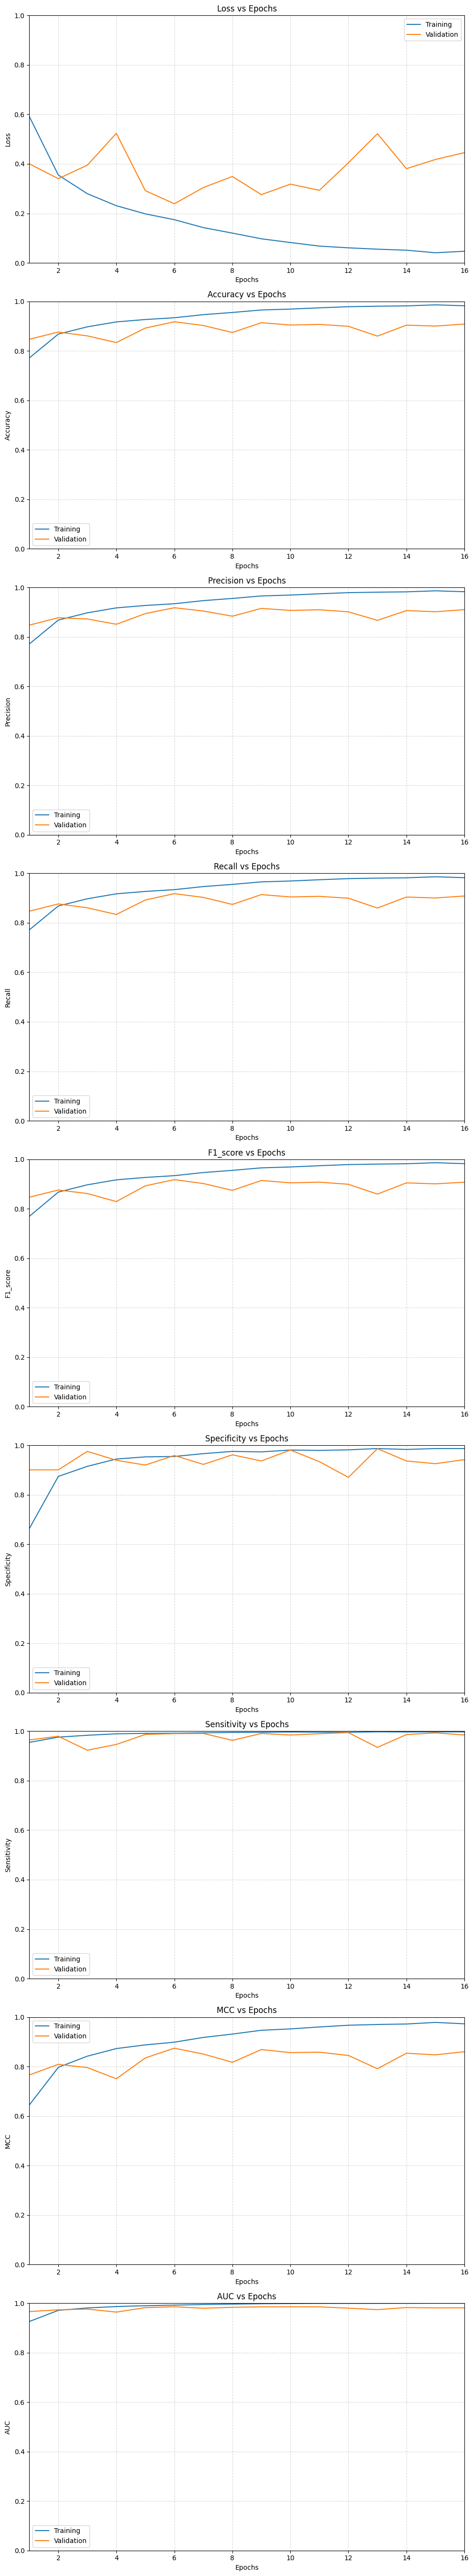

In [23]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [24]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 265/265 [00:30<00:00,  8.66it/s]

Metrics - loss: 0.3905, accuracy: 0.9176, precision: 0.9193, recall: 0.9176, f1_score: 0.9162, specificity: 0.9613, sensitivity: 0.9889, mcc: 0.8749, auc: 0.9821


In [26]:
true_labels = np.array(all_targets)

predicted_labels = np.argmax(np.array(all_predictions), axis=1)

true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                 precision    recall  f1-score   support

          COVID     0.9469    0.9613    0.9540       723
   Lung_Opacity     0.9415    0.8028    0.8666      1202
         Normal     0.8939    0.9632    0.9273      2039
Viral Pneumonia     0.9386    0.9665    0.9524       269

       accuracy                         0.9176      4233
      macro avg     0.9302    0.9235    0.9251      4233
   weighted avg     0.9193    0.9176    0.9162      4233

There were 349 errors in 4233 tests for an accuracy of  91.76


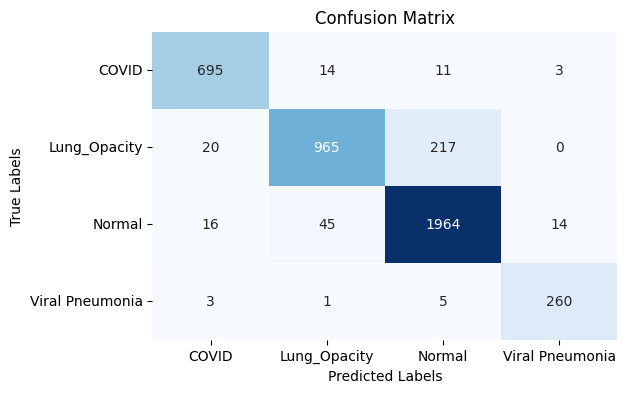

In [28]:
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()